In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
from PIL import Image
import random
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Storm_Figs_V6.6.2/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_hPa_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_hPa_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time, Birth_Time, Begin_Time, Compl_Time, Death_Time, Peak_Time = [], [], [], [], [], []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Birth_Time.append(Datetime(ET_DF["Genesis Time"][j]))
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Death_Time.append(Datetime(ET_DF["Dissipate Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["Genesis Time"] = Birth_Time
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Dissipate Time"] = Death_Time
    ET_DF["Peak Time"] = Peak_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    return (New_Time)

In [6]:
# Find a Specific Storm Within the DataFrame
def Find_Storm(DF, Code):
    DF_Storm = DF[DF["Code"] == Code].reset_index()
    return (DF_Storm)

In [7]:
# Create Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)

In [8]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [9]:
# Function to Find Distance Between Two Points
def Find_Distance(y1, y2, x1, x2):
    Start_Lat = y1 * numpy.pi / 180
    End_Lat = y2 * numpy.pi / 180
    Start_Lon = x1 * numpy.pi / 180
    End_Lon = x2 * numpy.pi / 180
    Lat_Diff = End_Lat - Start_Lat
    Lon_Diff = End_Lon - Start_Lon
    Earth_Rad = 6378
    Distance = 2 * Earth_Rad * numpy.sqrt((numpy.sin(Lat_Diff/2))**2 + \
    numpy.cos(Start_Lat) * numpy.cos(End_Lat) * (numpy.sin(Lon_Diff/2))**2)
    return (Distance)

In [10]:
# Create Function to Open Storm Composite Files
def Composite_File(File):
    Diri = '/glade/campaign/univ/upsu0032/Hyperion_ET/composites/'
    Compo_File = xr.open_dataset(Diri + File)
    return (Compo_File)

In [11]:
# Open Storm Composite Files
Control_A_Compo_nc = Composite_File('composite_h3_CHEY.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.002.nc')
Control_B_Compo_nc = Composite_File('composite_h3_CORI.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')
Control_C_Compo_nc = Composite_File('composite_h3_CHEY.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')

In [12]:
# Open Storm Composite Files
RCP45_A_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')
RCP45_B_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.002.nc')
RCP45_C_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')

In [13]:
# Open Storm Composite Files
RCP85_A_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')
RCP85_B_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')
RCP85_C_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.004.nc')

In [14]:
# Create DataFrame With Lat Lon Time Data of the Composite Files
def Composite_DF(Compo_nc, ABC):
    Snap_Time = pandas.Series(Compo_nc.snap_time)
    Snap_Lon = pandas.Series(Compo_nc.snap_lon)
    Snap_Lat = pandas.Series(Compo_nc.snap_lat)
    Snap_PathID = pandas.Series(Compo_nc.snap_pathid)
    Index = numpy.arange(0,len(Snap_Time),1)
    ABC_List = []
    for m in range(len(Index)):
        ABC_List.append(ABC)
    Compo_DF = pandas.DataFrame({"Orig Index": Index, "ABC": ABC_List, \
    "Time": Snap_Time, "Lon": Snap_Lon, "Lat": Snap_Lat, "PathID": Snap_PathID})
    return (Compo_DF)

In [15]:
# Combine Composite DFs
def Combine_Compo_DF(Compo_A, Compo_B, Compo_C):
    Compo_DF_A = Composite_DF(Compo_A, "A")
    Compo_DF_B = Composite_DF(Compo_B, "B")
    Compo_DF_C = Composite_DF(Compo_C, "C")
    Compo_DF = pandas.concat([Compo_DF_A, Compo_DF_B, Compo_DF_C]).reset_index()
    Compo_DF = Compo_DF.drop("index", axis=1)
    return (Compo_DF)

In [16]:
Control_Compo = Combine_Compo_DF(Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc)

In [17]:
RCP45_Compo = Combine_Compo_DF(RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc)

In [18]:
RCP85_Compo = Combine_Compo_DF(RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc)

In [19]:
# Change Year of Data
def Reverse_Update_Year(New_Time, Year_Diff):
    Year_Orig = New_Time.year + Year_Diff
    Orig_Time = New_Time.replace(year=Year_Orig)
    return (Orig_Time)

In [20]:
# Create Function to Find Year Diff
def Year_Diff_Find(New_Time):
    Years = [1900,1930,1960,2000,2031,2062,2100,2131,2162,2193]
    New_Time_Index = -728
    for i in range(len(Years)):
        if i < 3:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 1985 - Years[i]
                New_Time_Index = i
        elif i < 6:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 2070 - Years[i]
                New_Time_Index = i
        else:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 2070 - Years[i]
                New_Time_Index = i
    if New_Time_Index % 3 == 0:
        ABC = "A"
    elif New_Time_Index % 3 == 1:
        ABC = "B"
    elif New_Time_Index % 3 == 2:
        ABC = "C"
    return (int(Year_Diff), ABC)

In [21]:
# Create Function to Find Indexes of Composite Data For Selected Storm
def Find_Composite_Data(Code, Data_DF, Compo_DF):
    DF_Storm = Find_Storm(Data_DF, Code)
    New_Time = DF_Storm["Time(Z)"]
    Lat = DF_Storm["Lat"]
    Lon = DF_Storm["Lon"]
    SLP = DF_Storm["SLP(hPa)"]
    Windspeed = DF_Storm["Winds(m/s)"]
    Storm_Phase = DF_Storm["Storm Phase"]
    Compo_Indexes = numpy.zeros(len(New_Time))
    for i in range(len(New_Time)):
        Year_Diff, ABC = Year_Diff_Find(New_Time[0])
        Orig_Time = Reverse_Update_Year(New_Time[i], Year_Diff)
# Find Possible Storms that Occur at the Same Time
        Compo_Storm = Compo_DF[(Compo_DF["ABC"] == ABC) & (Compo_DF["Time"] == Orig_Time)].reset_index()
# If No Storm Found:
        if len(Compo_Storm) == 0:
            Compo_Indexes[i] = -728
# Storms Found:
        else:
            Dist_Min = [7428,-728]
            for c in range(len(Compo_Storm)):
                Dist = Find_Distance(Lat[i], Compo_Storm["Lat"][c], Lon[i], Compo_Storm["Lon"][c])
# Find Storm Closest to Storm Center
                if Dist < Dist_Min[0]:
# At Most 300km of Error in Location Permitted
                    if Dist < 300:
                        Dist_Min = [Dist, Compo_Storm["Orig Index"][c]]
                    else:
                        Dist_Min = [Dist, -728]
            Compo_Indexes[i] = Dist_Min[1]
    DF_Storm_Compo_Init = pandas.DataFrame({"Compo Index": Compo_Indexes, "Time": New_Time, \
    "Lon": Lon, "Lat": Lat, "SLP(hPa)": SLP, "Sfc Winds(m/s)": Windspeed, "Storm Phase": Storm_Phase})
# Remove Datapoints With Missing Compo Index
    DF_Storm_Compo = DF_Storm_Compo_Init[DF_Storm_Compo_Init["Compo Index"] >= 0].reset_index()
    DF_Storm_Compo = DF_Storm_Compo.drop("index", axis=1)
    return (DF_Storm_Compo)

In [22]:
# Find 850hPa Windspeed From Compo File
def Windspeed_850hPa(Compo_nc, Compo_Index):
    U850 = numpy.array(Compo_nc.snap_U850[int(Compo_Index)])
    V850 = numpy.array(Compo_nc.snap_V850[int(Compo_Index)])
    Snap_850 = numpy.sqrt(U850 **2 + V850 **2)
    return (Snap_850)

In [23]:
# Find Total Precip Rate From Compo File
def Precip(Compo_nc, Compo_Index):
    Precip_ms = numpy.array(Compo_nc.snap_PRECT[int(Compo_Index)])
    Precip_mmhr = Precip_ms * 3600 * 1000
    return (Precip_mmhr)

In [24]:
# Find 850hPa Max Windspeed and Wind Field Size at Each 6 Hourly Data Point
def Wind_Field_Find(DF_Storm_Compo, Compo_nc):
    Compo_Index = DF_Storm_Compo["Compo Index"]
    Time_List = DF_Storm_Compo["Time"]
    SLP = DF_Storm_Compo["SLP(hPa)"]
#
# Create Array to Store Data
    Wind_Field_Info = numpy.zeros((5,len(Compo_Index)))
    Wind_Field_Info[0] = SLP
#
# At Each 6 Hourly Data Point
    for k in range(len(Compo_Index)):
# Find 850hPa Windspeed Snap From Compo_nc
        Snap_850 = Windspeed_850hPa(Compo_nc, Compo_Index[k])
# Find Maximum 850hPa Windspeed
        Windspeed_850 = numpy.max(Snap_850)
# Count Number of Data Points With Windspeed Above 18,25,33m/s
        Snap_Sort = numpy.sort(Snap_850.ravel())
        Count_18 = len(Snap_Sort[Snap_Sort >= 18])
        Count_25 = len(Snap_Sort[Snap_Sort >= 25])
        Count_33 = len(Snap_Sort[Snap_Sort >= 33])
        Wind_Field_Info[1][k] = Windspeed_850
        Wind_Field_Info[2][k] = Count_18
        Wind_Field_Info[3][k] = Count_25
        Wind_Field_Info[4][k] = Count_33
#
# Add Wind Field Info Into DF Storm Compo
    DF_Storm_Compo["850hPa Winds"] = Wind_Field_Info[1]
    DF_Storm_Compo["850hPa 18m/s"] = Wind_Field_Info[2]
    DF_Storm_Compo["850hPa 25m/s"] = Wind_Field_Info[3]
    DF_Storm_Compo["850hPa 33m/s"] = Wind_Field_Info[4]
    return (Wind_Field_Info, Time_List, DF_Storm_Compo)

In [25]:
# Plot Wind Field Information
def SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Snapshot_Index, Savefig):
# Find Storm
    DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
    ET_Storm = Find_Storm(ET_DF, Code)
#
# Use Function to Calculate Wind Field Information
    Wind_Field_Info, Time_List, DF_Storm_Compo_Wind_Field = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
#
# Define Colours
    Colour_1 = 'red'
    Colour_2 = 'mediumblue'
#    Colour_3 = 'darkorange'
#
# Axis For Max Windspeed
    Fig, Ax1 = pyplot.subplots(figsize=(8,6))
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax1.scatter(Time_List[k], DF_Storm_Compo_Wind_Field["850hPa Winds"][k], c=Colour_1, marker=Shape, s=38)
#        Ax1.scatter(Time_List[k], DF_Storm_Compo_Wind_Field["Sfc Winds(m/s)"][k], c=Colour_3, marker=Shape, s=38)
    Ax1.plot(Time_List, DF_Storm_Compo_Wind_Field["850hPa Winds"], color=Colour_1, linewidth=1.2, \
    label='850hPa Windspeed')
#    Ax1.plot(Time_List, DF_Storm_Compo_Wind_Field["Sfc Winds(m/s)"], color=Colour_3, linewidth=1.2, \
#    label='Surface Windspeed')
#    pyplot.legend(loc=1)
#
# Axis For Wind Field Size
    Ax2 = Ax1.twinx()
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax2.scatter(Time_List[k], DF_Storm_Compo_Wind_Field["SLP(hPa)"][k], c=Colour_2, marker=Shape, s=28)
    Ax2.plot(Time_List, Wind_Field_Info[0], color=Colour_2, linewidth=1.2, label='Sea Level Pressure')
#
# Formatting
    Ax1, Ax2 = SLP_Windspeed_Axis(Wind_Field_Info[0], Ax1, Ax2)
    Ax2 = Time_Axis(Time_List, Ax2)
    Gridline = Ax1.grid(linewidth=0.5, color='silver', linestyle='-')
    Ax1.set_ylabel('Max 850hPa Windspeed (m/s)', color=Colour_1, fontsize=12)
    Ax1.tick_params(axis='y', labelcolor=Colour_1)
    Ax2.set_ylabel('Sea Level Pressure (hPa)', color=Colour_2, fontsize=12)
    Ax2.tick_params(axis='y', labelcolor=Colour_2)
    Title = str(Code + ' ' + Storm_Name + " -- Min SLP & Max 850hPa Windspeed")
    pyplot.title(Title, fontsize=18)
#
# Plot Lines Denoting Snapshot Times
    if len(Snapshot_Index) > 0:
        for s in range(len(Snapshot_Index)):
            Time = list(DF_Storm_Compo[DF_Storm_Compo["Compo Index"] == Snapshot_Index[s]]["Time"])[0]
            Ax2.plot([Time, Time], [0,7428], c='black', linestyle='--', linewidth=0.8)
    Fig.tight_layout()
#
# Save Fig
    if Savefig == True:
        Figname = str(Code + '_' + Storm_Name + '_SLP_Winds.png')
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [26]:
# Plot Wind Field Information
def Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Snapshot_Index, Savefig):
# Find Storm
    DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
    ET_Storm = Find_Storm(ET_DF, Code)
#
# Use Function to Calculate Wind Field Information
    Wind_Field_Info, Time_List, DF_Storm_Compo_Wind_Field = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
#
# Define Colours
    Colour_2 = 'lightseagreen'
    Colour_3 = 'limegreen'
    Colour_4 = 'gold'
#
# Axis For Wind Field Size
    Fig, Ax1 = pyplot.subplots(figsize=(8,6))
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax1.scatter(Time_List[k], Wind_Field_Info[2][k], c=Colour_2, marker=Shape, s=28)
        Ax1.scatter(Time_List[k], Wind_Field_Info[3][k], c=Colour_3, marker=Shape, s=28)
        Ax1.scatter(Time_List[k], Wind_Field_Info[4][k], c=Colour_4, marker=Shape, s=28)
    Ax1.plot(Time_List, Wind_Field_Info[2], color=Colour_2, linewidth=1.2, label='# Datapoints >= 18m/s')
    Ax1.plot(Time_List, Wind_Field_Info[3], color=Colour_3, linewidth=1.2, label='# Datapoints >= 25m/s')
    Ax1.plot(Time_List, Wind_Field_Info[4], color=Colour_4, linewidth=1.2, label='# Datapoints >= 33m/s')
    pyplot.legend(loc=2)
#
# Formatting
    Ax1 = Wind_Field_Axis(Wind_Field_Info[2], Ax1)
    Ax1 = Time_Axis(Time_List, Ax1)
    Gridline = Ax1.grid(linewidth=0.5, color='silver', linestyle='-')
    Ax1.set_ylabel('# Gridpoints', color='darkgreen', fontsize=12)
    Ax1.tick_params(axis='y', labelcolor='darkgreen')
    Title = str(Code + ' ' + Storm_Name + " -- 850hPa Wind Field")
    pyplot.title(Title, fontsize=18)
#
# Plot Lines Denoting Snapshot Times
    if len(Snapshot_Index) > 0:
        for s in range(len(Snapshot_Index)):
            Time = list(DF_Storm_Compo[DF_Storm_Compo["Compo Index"] == Snapshot_Index[s]]["Time"])[0]
            Ax1.plot([Time, Time], [0,7428], c='black', linestyle='--', linewidth=0.8)
    Fig.tight_layout()
#
# Save Fig
    if Savefig == True:
        Figname = str(Code + '_' + Storm_Name + '_Wind_Field_850hPa.png')
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [27]:
def Time_Axis(Time, Ax2):
    x_Min = Time[0] + datetime.timedelta(hours=-6)
    x_Max = Time[len(Time)-1] + datetime.timedelta(hours=6)
    x_Start = datetime.date(x_Min.year,x_Min.month,x_Min.day) + datetime.timedelta(1)
    x_End = datetime.date(x_Max.year,x_Max.month,x_Max.day) + datetime.timedelta(1)
    if len(Time) < 60:
        x_Axis = pandas.date_range(x_Start,x_End,freq='2D')
    else:
        x_Axis = pandas.date_range(x_Start,x_End,freq='3D')
    Ax2.set_xlabel('Time (Z)', fontsize=12)
    Ax2.set_xticks(x_Axis)
    Ax2.set_xlim(x_Min,x_Max)
    return (Ax2)

In [28]:
def SLP_Windspeed_Axis(SLP, Ax1, Ax2):
    y_Min = int(numpy.min(SLP) / 10) * 10
    if y_Min > 940:
        Ax2.set_yticks(Create_Bins(940,1020,10))
        Ax2.set_ylim(940,1020)
        Ax1.set_yticks(Create_Bins(0,80,10))
        Ax1.set_ylim(0,80)
    else:
        Ax2.set_yticks(Create_Bins(y_Min,1020,10))
        Ax2.set_ylim(y_Min,1020)
        y_Max = 1020-y_Min
        Ax1.set_yticks(Create_Bins(0,y_Max,10))
        Ax1.set_ylim(0,y_Max)
    return (Ax1, Ax2)

In [29]:
def Wind_Field_Axis(Gale_Count, Ax1):
    y_Max = int(numpy.max(Gale_Count) / 100 + 1) * 100
    if y_Max <= 600:
        Ax1.set_yticks(Create_Bins(0,600,50))
        Ax1.set_ylim(0,600)
    elif y_Max <= 1200:
        Ax1.set_yticks(Create_Bins(0,y_Max,100))
        Ax1.set_ylim(0,y_Max)
    elif y_Max <= 3000:
        Ax1.set_yticks(Create_Bins(0,y_Max,200))
        Ax1.set_ylim(0,y_Max)
    else:
        Ax1.set_yticks(Create_Bins(0,y_Max,500))
        Ax1.set_ylim(0,y_Max)
    return (Ax1)

In [30]:
# Plot Marker
def Plot_Marker(Storm_Phase):
    if Storm_Phase == "Tropical":
        Shape = 'o'
    elif Storm_Phase == "Transition":
        Shape = 's'
    else:
        Shape = '^'
    return (Shape)

In [31]:
# Define Colours and Bounds
Windspeed_Colours = ['white', 'cyan', 'lightseagreen', 'limegreen', 'gold', 'darkorange', 'red', 'darkviolet']
Windspeed_Bounds = numpy.array([13,18,25,33,41,50,60])
Precip_Colours = ['white', 'cyan', 'deepskyblue', 'dodgerblue', 'lightseagreen', 'limegreen', 'greenyellow', \
'gold', 'darkorange', 'red', 'darkviolet']
Precip_Bounds = numpy.array([0.1,0.5,1,2,5,10,20,30,50,70])

In [32]:
# Create Function to Plot Contour Maps
def Contour_Map(Snap, x_Snap, y_Snap, Bounds, Colours, Storm_Name, Time_Label, Var, x_Label):
# Add Corrdinate Lines
    pyplot.plot([-728,728], [0,0], c='black', linestyle='-', linewidth=0.8)
    pyplot.plot([0,0], [-728,728], c='black', linestyle='-', linewidth=0.8)
# Initial Indexes
    i_Init = 0
    j_Init = 0
    i_Fin = 80
    j_Fin = 80
# Plot Contour Map
    pyplot.contourf(x_Snap, y_Snap, Snap, levels=Bounds, colors=Colours, extend='both')
# Formatting
    x_Min = float(x_Snap[i_Init])
    x_Max = float(x_Snap[i_Fin-1])
    y_Min = float(y_Snap[j_Init])
    y_Max = float(y_Snap[j_Fin-1])
    pyplot.xlim(x_Min,x_Max)
    pyplot.ylim(y_Min,y_Max)
    if x_Label == True:
        pyplot.xlabel('Lon Diff From Storm Center', fontsize=12)
    pyplot.ylabel('Lat Diff From Storm Center', fontsize=12)
#    pyplot.grid(linewidth=0.3, color='silver', linestyle='-')
    Title = str(Storm_Name + (' -- ') + Time_Label)
    pyplot.title(Title, fontsize=18)

In [33]:
# Plot Four Windspeed Snap Plots
def Windspeed_Snap_Plots(Compo_nc, DF, Code, Storm_Name, Indexes, Time_Labels, Bounds, Colours, Savefig):
# x and y Values
    x_Snap = Compo_nc.x
    y_Snap = Compo_nc.y
    Storm_Code_Name = str(Code + ' ' + Storm_Name)
#
# Create Fig
    Fig = pyplot.figure(figsize=(16,16))
# First Plot
    Axis = Fig.add_subplot(2,2,1)
    Windspeed_Snap_1 = numpy.array(Windspeed_850hPa(Compo_nc, Indexes[0]))
    Contour_Map(Windspeed_Snap_1, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[0], "Windspeed", False)
#
# Second Plot
    Axis = Fig.add_subplot(2,2,2)
    Windspeed_Snap_2 = numpy.array(Windspeed_850hPa(Compo_nc, Indexes[1]))
    Contour_Map(Windspeed_Snap_2, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[1], "Windspeed", False)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("850hPa Windspeeds", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([-0.85, -0.095, 1.5, 0.025], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', \
    cax=Cax, label='850hPa Windspeeds (m/s)', shrink=0.7)
#
# Third Plot
    Axis = Fig.add_subplot(2,2,3)
    Windspeed_Snap_3 = numpy.array(Windspeed_850hPa(Compo_nc, Indexes[2]))
    Contour_Map(Windspeed_Snap_3, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[2], "Windspeed", True)
#
# Fourth Plot
    Axis = Fig.add_subplot(2,2,4)
    Windspeed_Snap_4 = numpy.array(Windspeed_850hPa(Compo_nc, Indexes[3]))
    Contour_Map(Windspeed_Snap_4, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[3], "Windspeed", True)
#
# Save Fig
    if Savefig == True:
        Figname = str(Code + '_' + Storm_Name + '_Wind_Snapshot.png')
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [34]:
# Plot Four Precip Rate Snap Plots
def Precip_Snap_Plots(Compo_nc, DF, Code, Storm_Name, Indexes, Time_Labels, Bounds, Colours, Savefig):
# x and y Values
    x_Snap = Compo_nc.x
    y_Snap = Compo_nc.y
    Storm_Code_Name = str(Code + ' ' + Storm_Name)
#
# Create Fig
    Fig = pyplot.figure(figsize=(16,16))
# First Plot
    Axis = Fig.add_subplot(2,2,1)
    Precip_Snap_1 = Precip(Compo_nc, Indexes[0])
    Contour_Map(Precip_Snap_1, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[0], "Precip", False)
#
# Second Plot
    Axis = Fig.add_subplot(2,2,2)
    Precip_Snap_2 = Precip(Compo_nc, Indexes[1])
    Contour_Map(Precip_Snap_2, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[1], "Precip", False)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("Precip Rate", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([-0.85, -0.095, 1.5, 0.025], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', \
    cax=Cax, label='Total Precip Rate (mm/hr)', shrink=0.7)
#
# Third Plot
    Axis = Fig.add_subplot(2,2,3)
    Precip_Snap_3 = Precip(Compo_nc, Indexes[2])
    Contour_Map(Precip_Snap_3, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[2], "Precip", True)
#
# Fourth Plot
    Axis = Fig.add_subplot(2,2,4)
    Precip_Snap_4 = Precip(Compo_nc, Indexes[3])
    Contour_Map(Precip_Snap_4, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[3], "Precip", True)
#
# Save Fig
    if Savefig == True:
        Figname = str(Code + '_' + Storm_Name + '_Precip_Snapshot.png')
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [35]:
# Some Example Storms

In [36]:
# Find Wind Field Composite Data
Code = "TC191304"
Storm_Name = "Melody"
Data_DF = Control_Data
ET_DF = Control_ET
Compo_DF = Control_Compo
Compo_nc = Control_A_Compo_nc
Time_Indexes = [3972,3987,3993,3999]
Time_Labels = ["Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
Wind_Field_Info, Time_List, DF_Storm_Compo_Wind_Field = Wind_Field_Find(DF_Storm_Compo, Compo_nc)

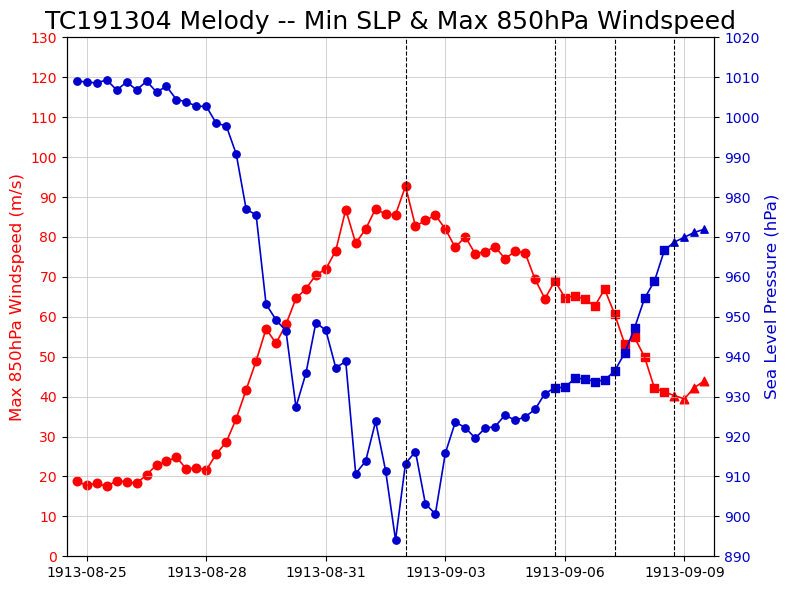

In [37]:
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

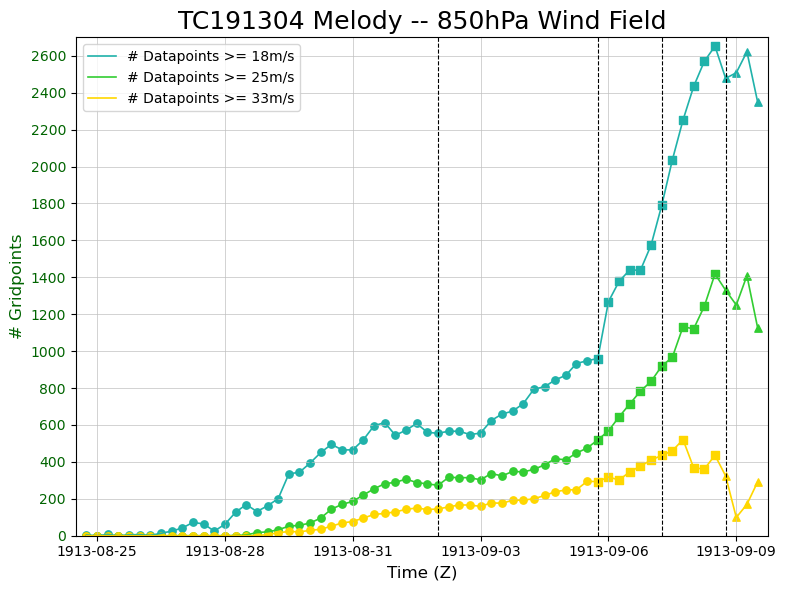

In [38]:
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

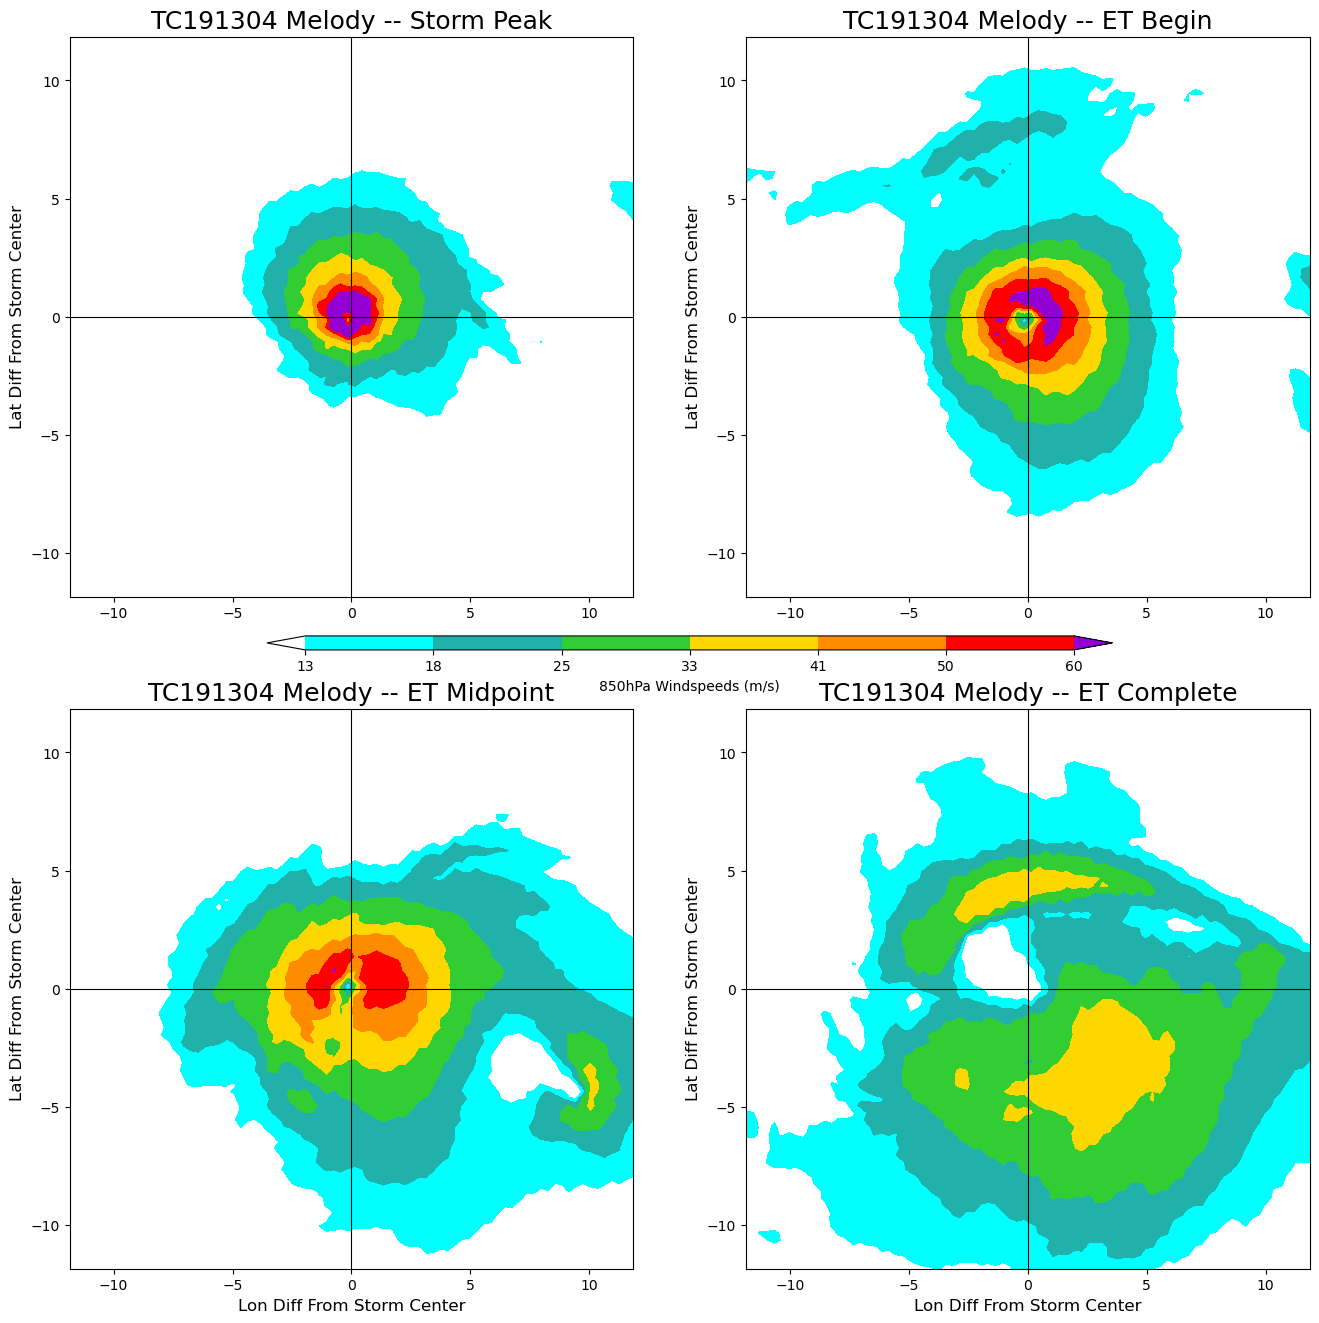

In [39]:
# Plot 850hPa Wind Field Snapshots
Windspeed_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Windspeed_Bounds, Windspeed_Colours, True)

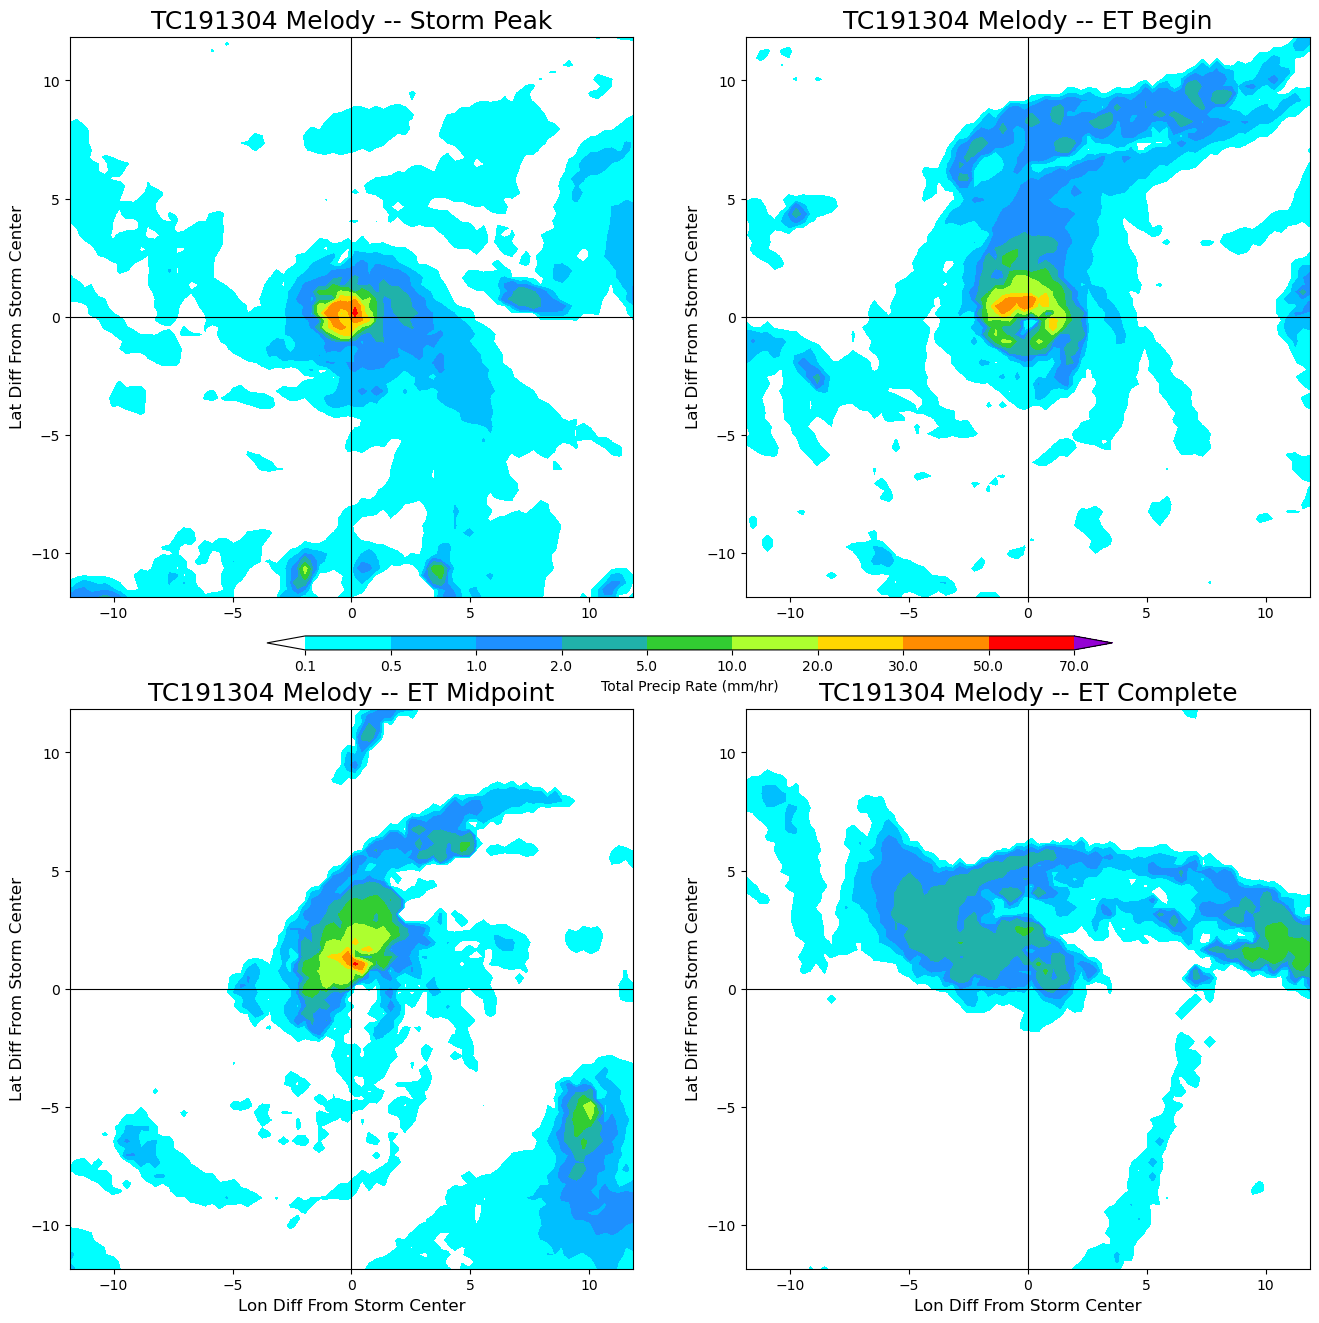

In [40]:
# Plot Precip Rate Snapshots
Precip_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Precip_Bounds, Precip_Colours, True)

In [41]:
# Find Wind Field Composite Data
Code = "TC202006"
Storm_Name = "Grace"
Data_DF = RCP45_Data
ET_DF = RCP45_ET
Compo_DF = RCP45_Compo
Compo_nc = RCP45_A_Compo_nc
Time_Indexes = [4651,4656,4657,4658]
Time_Labels = ["Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
Wind_Field_Info, Time_List, DF_Storm_Compo_Wind_Field = Wind_Field_Find(DF_Storm_Compo, Compo_nc)

In [42]:
DF_Storm_Compo_Wind_Field.head()

,Compo Index,Time,Lon,Lat,SLP(hPa),Sfc Winds(m/s),Storm Phase,850hPa Winds,850hPa 18m/s,850hPa 25m/s,850hPa 33m/s
0,4619.0,2020-08-10 12:00:00,-32.43,17.00,1009.93,12.2,Tropical,19.661705,18.0,0.0,0.0
1,4620.0,2020-08-10 18:00:00,-33.72,16.70,1007.71,14.4,Tropical,18.166122,1.0,0.0,0.0
2,4621.0,2020-08-11 00:00:00,-34.29,17.04,1008.61,19.4,Tropical,18.114784,1.0,0.0,0.0
3,4622.0,2020-08-11 06:00:00,-36.03,17.92,1008.40,20.1,Tropical,20.589302,25.0,0.0,0.0
4,4623.0,2020-08-11 12:00:00,-38.00,18.71,1010.18,18.2,Tropical,22.287758,36.0,0.0,0.0


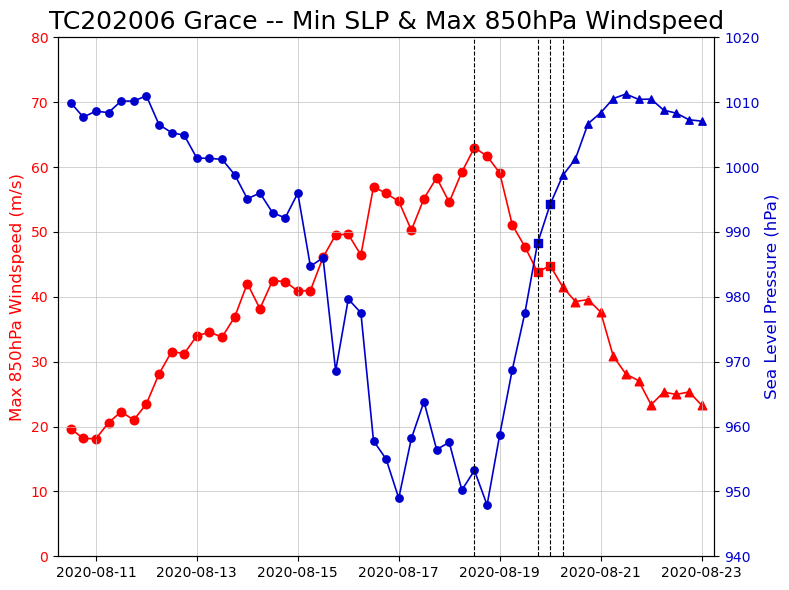

In [43]:
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

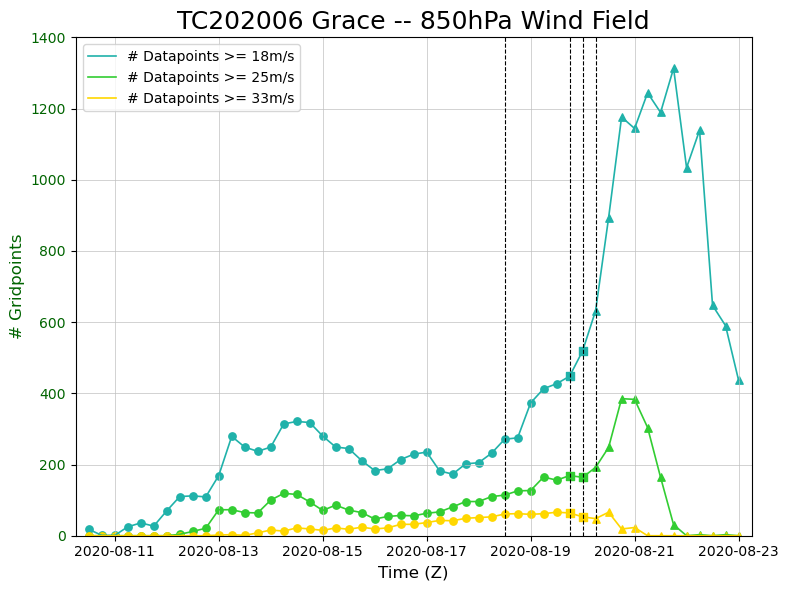

In [44]:
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

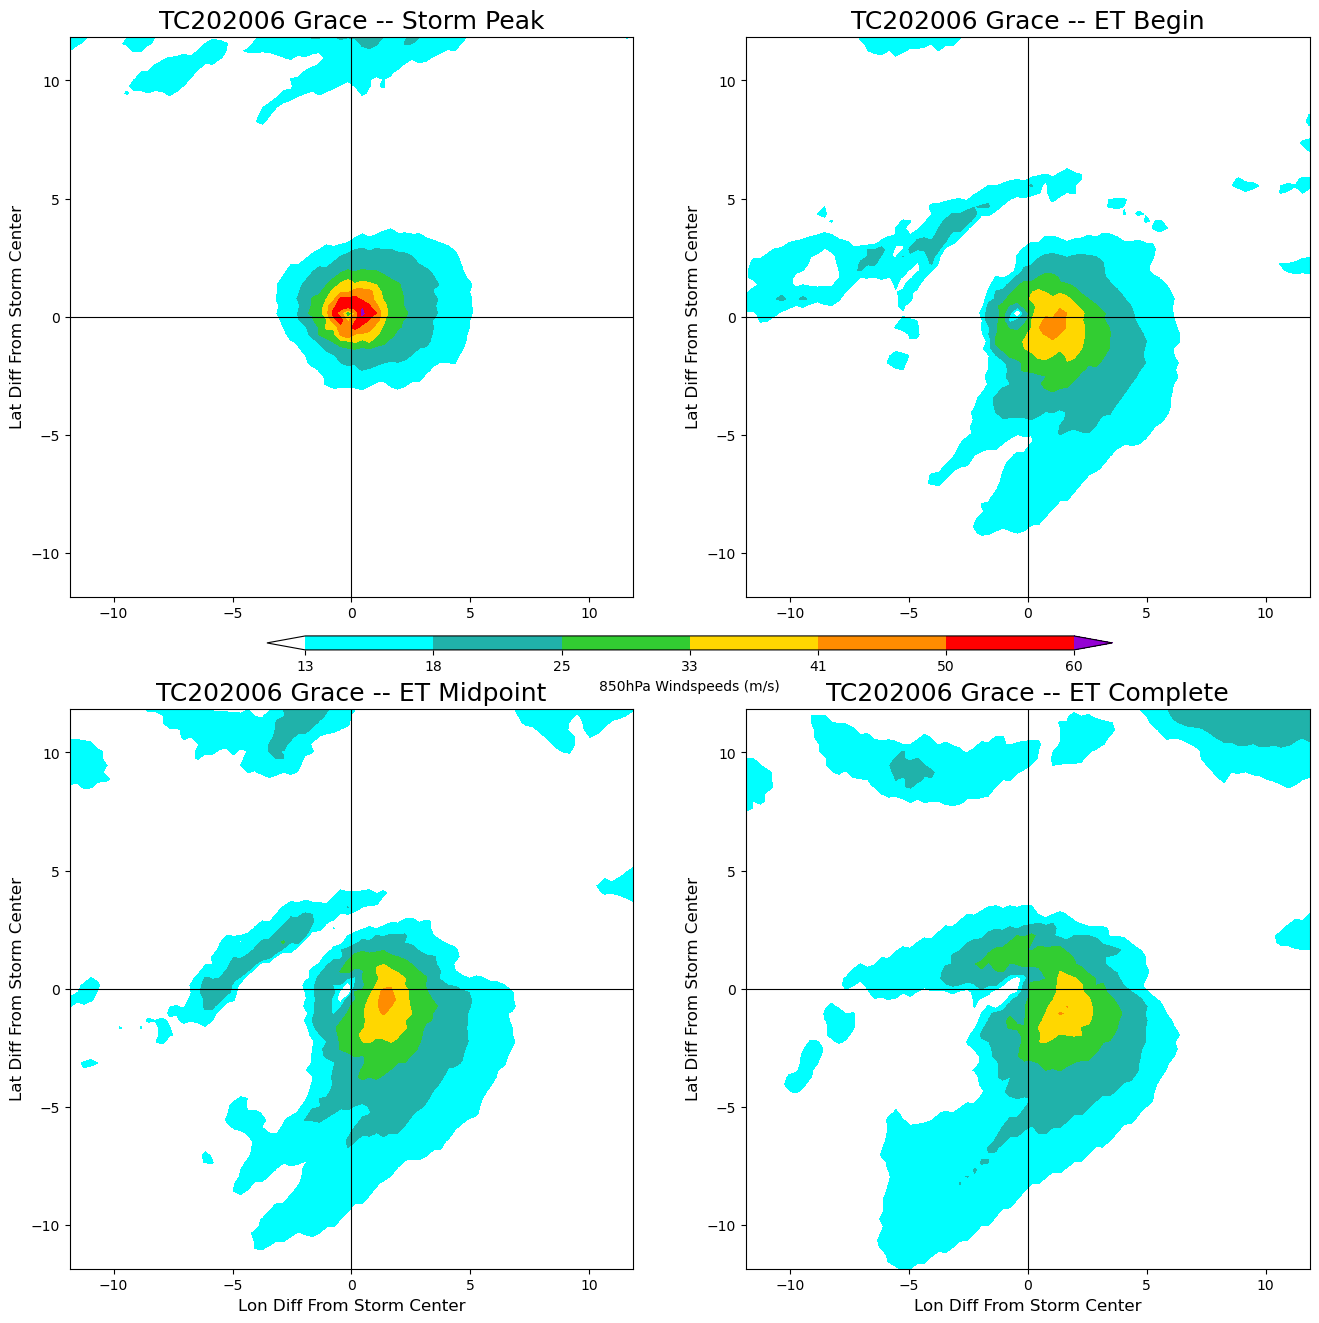

In [45]:
# Plot 850hPa Wind Field Snapshots
Windspeed_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Windspeed_Bounds, Windspeed_Colours, True)

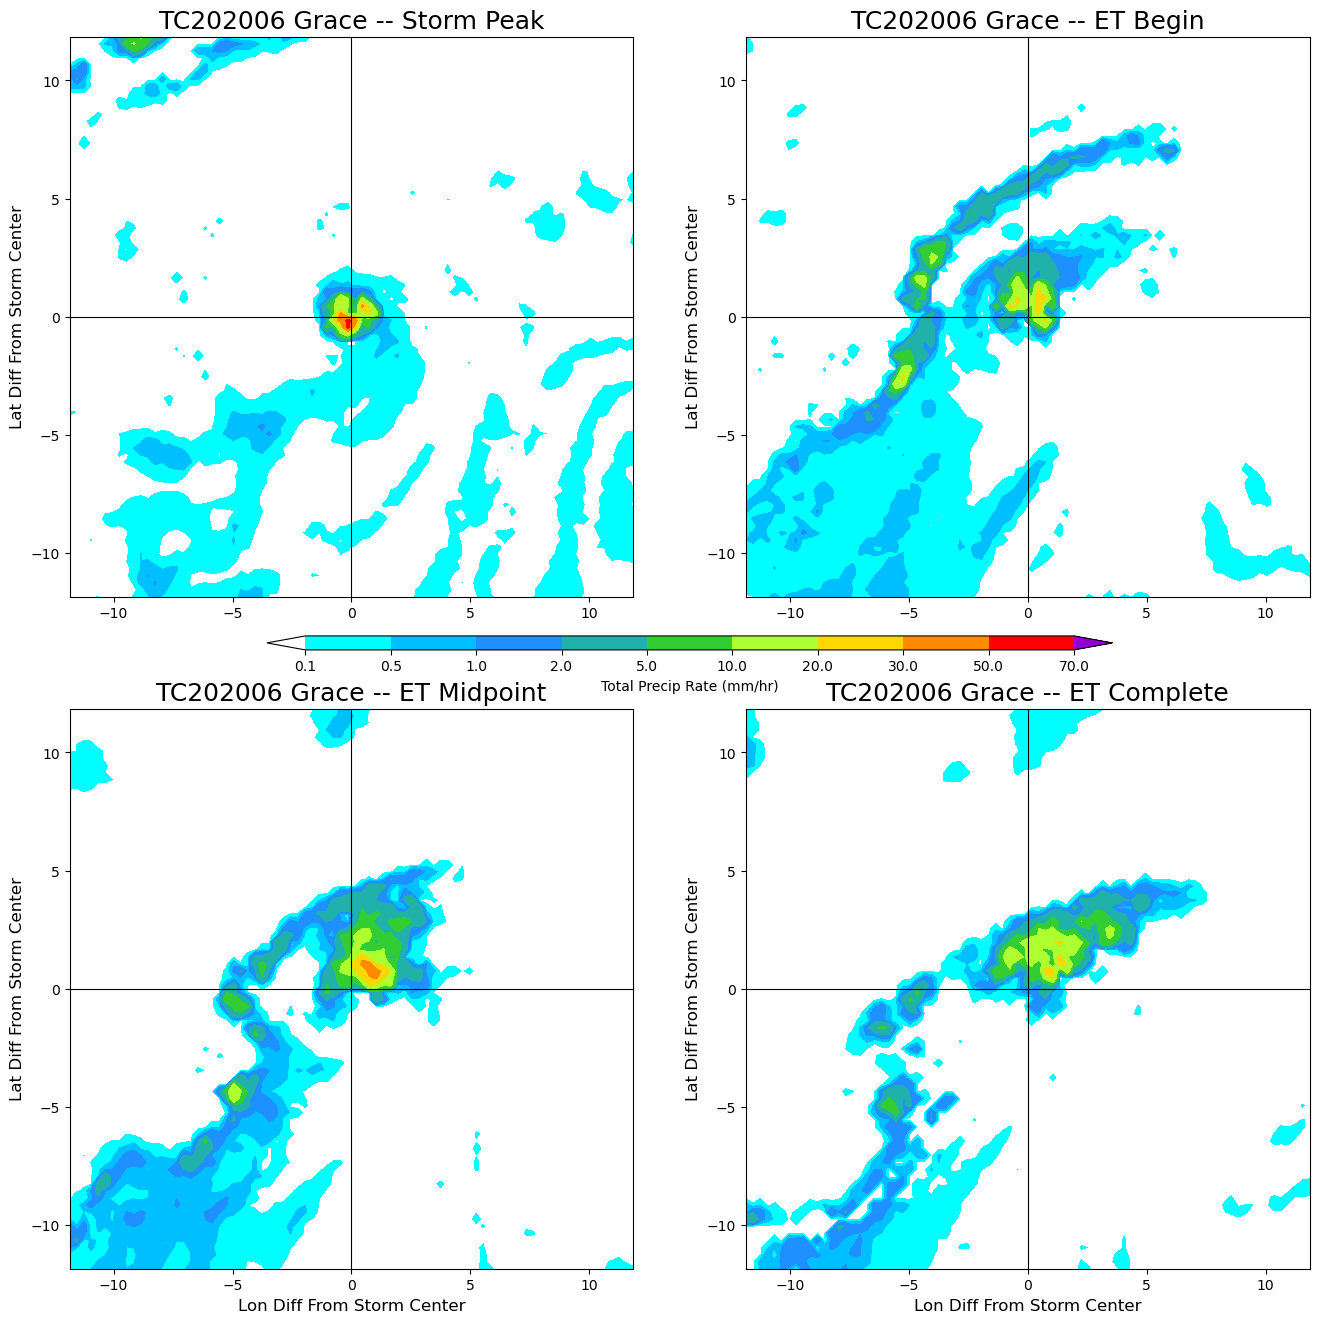

In [46]:
# Plot Precip Rate Snapshots
Precip_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Precip_Bounds, Precip_Colours, True)

In [47]:
# Find Wind Field Composite Data
Code = "TC216105"
Storm_Name = "Rachel"
Data_DF = RCP85_Data
ET_DF = RCP85_ET
Compo_DF = RCP85_Compo
Compo_nc = RCP85_B_Compo_nc
Time_Indexes = [6823,6837,6841,6845]
Time_Labels = ["First Storm Peak", "Storm Peak/ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
Wind_Field_Info, Time_List, DF_Storm_Compo_Wind_Field = Wind_Field_Find(DF_Storm_Compo, Compo_nc)

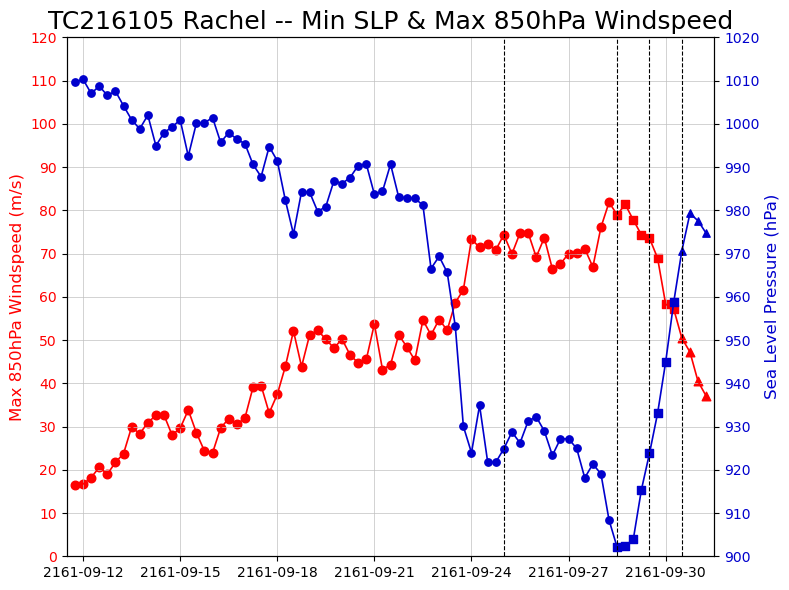

In [48]:
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

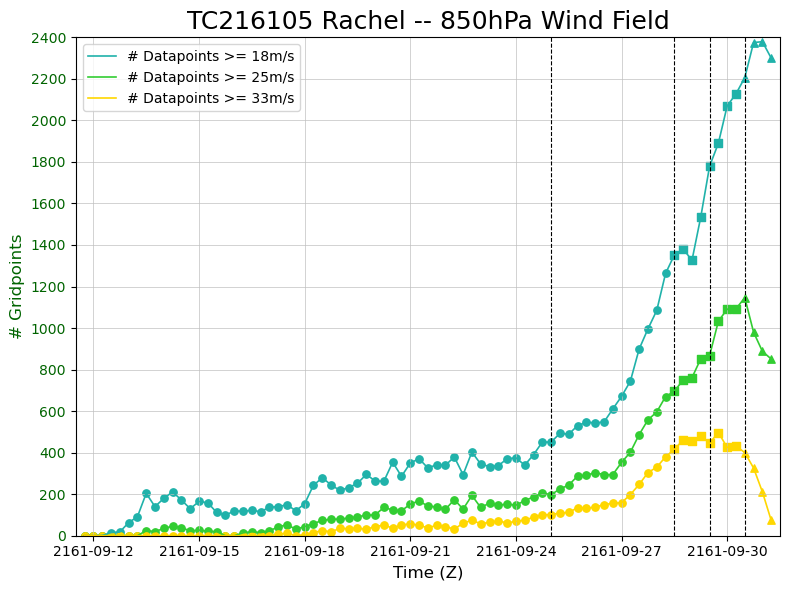

In [49]:
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

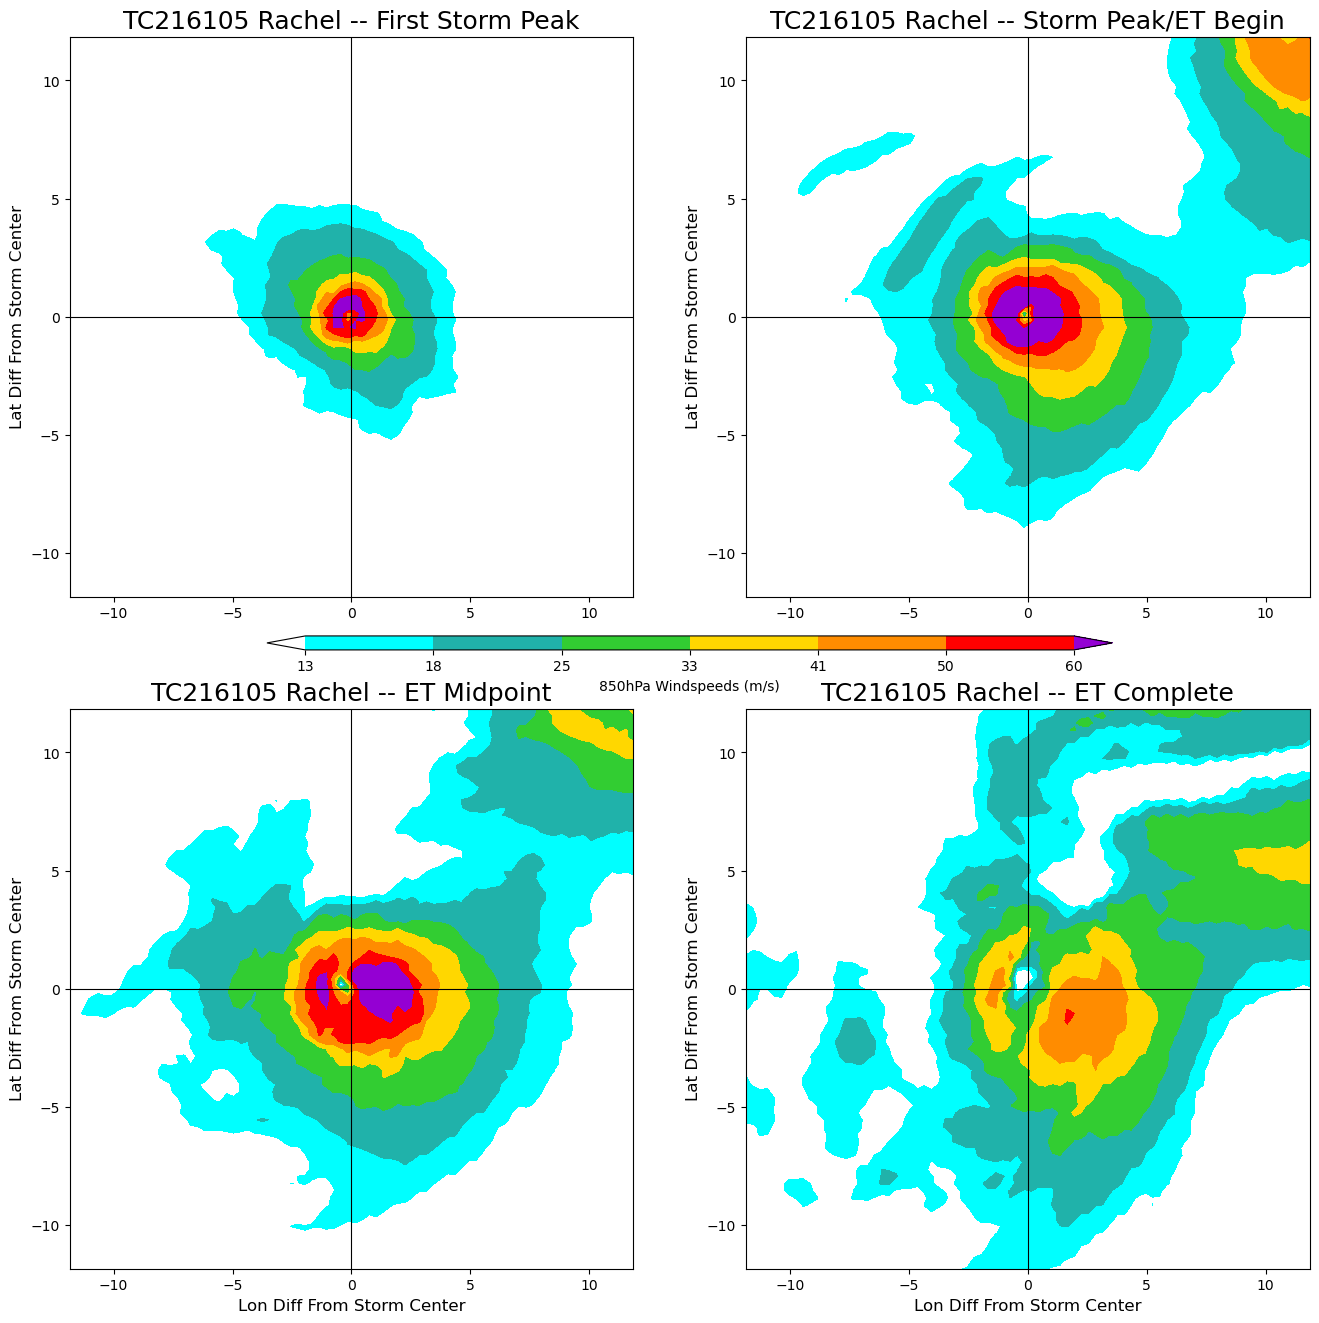

In [50]:
# Plot 850hPa Wind Field Snapshots
Windspeed_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Windspeed_Bounds, Windspeed_Colours, True)

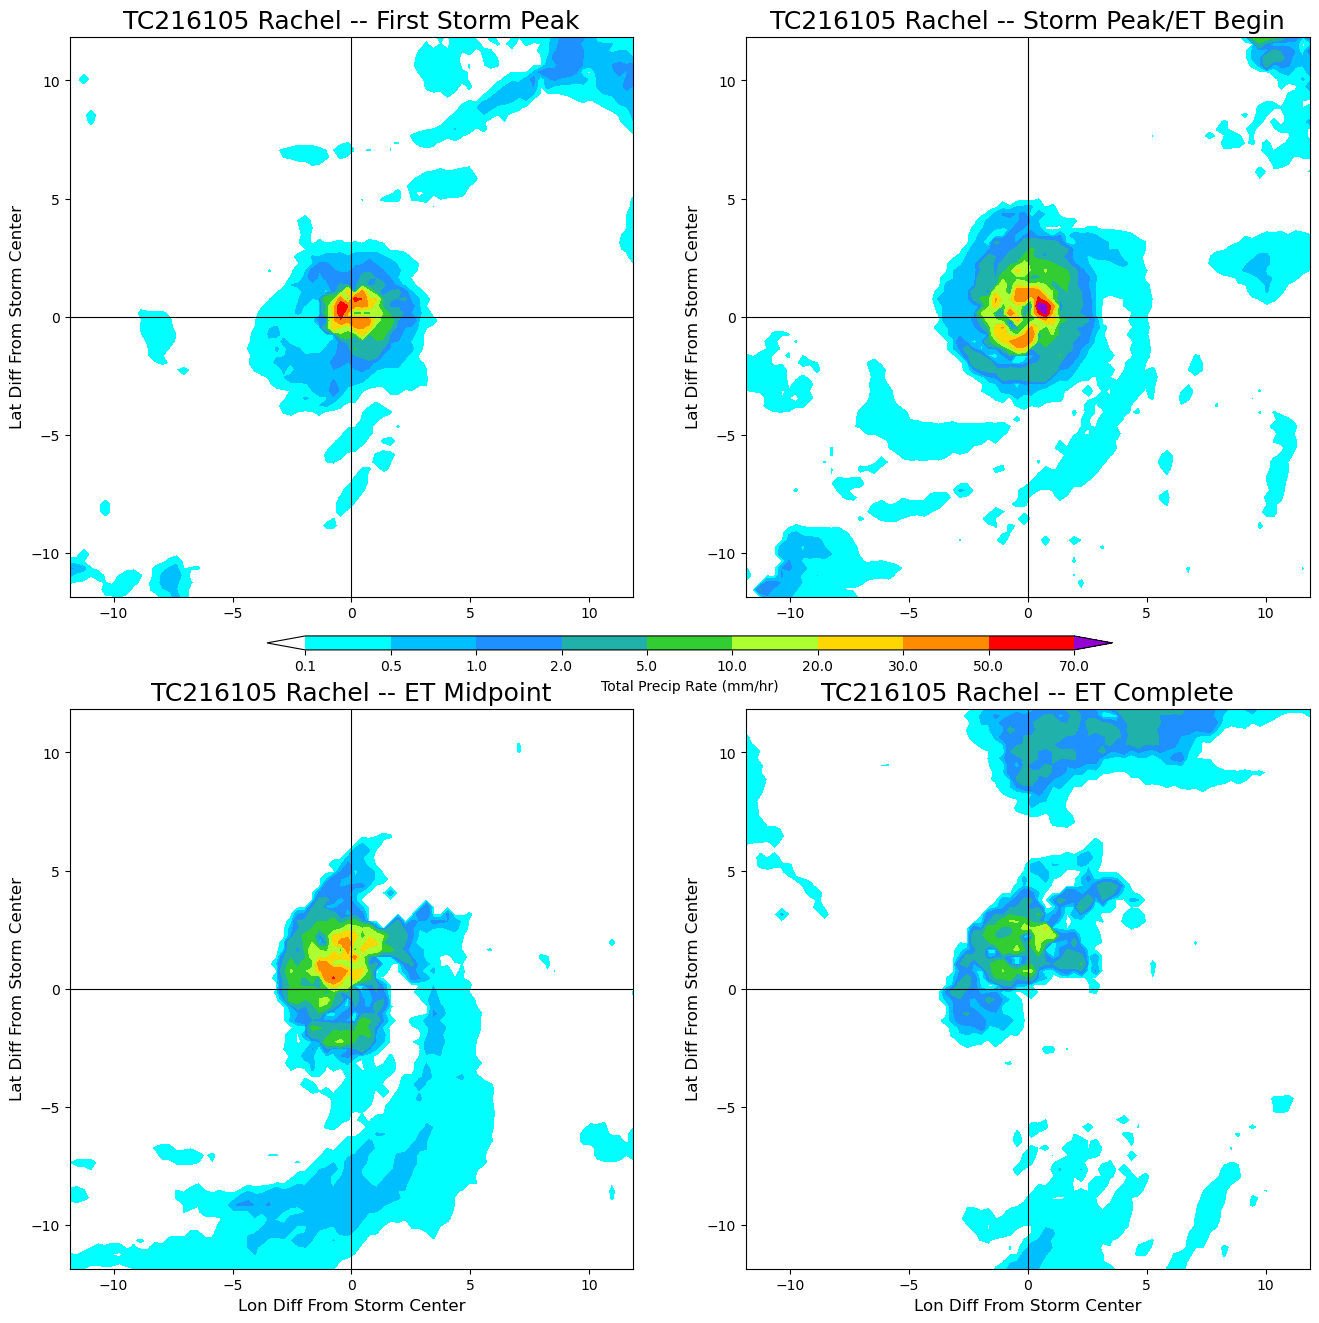

In [51]:
# Plot Precip Rate Snapshots
Precip_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Precip_Bounds, Precip_Colours, True)